# Example of using feature importances calculated by ExtraTreesClassifier

In [1]:
require 'matplotlib/iruby'
Matplotlib::IRuby.activate
plt = Matplotlib::Pyplot
nil

In [2]:
require 'pycall/import'
include PyCall::Import
pyimport 'numpy', as: 'np'
pyfrom 'sklearn.datasets', import: :fetch_olivetti_faces
pyfrom 'sklearn.datasets', import: :make_classification
pyfrom 'sklearn.ensemble', import: :ExtraTreesClassifier
nil

## (1) Feature importances with forests of trees

This section is based on the following content of the reference of scikit-learn:

- http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

Feature ranking:
1. feature 1 (0.295902)
2. feature 2 (0.208351)
3. feature 0 (0.177632)
4. feature 3 (0.047121)
5. feature 6 (0.046303)
6. feature 8 (0.046013)
7. feature 7 (0.045575)
8. feature 4 (0.044614)
9. feature 9 (0.044577)
10. feature 5 (0.043912)


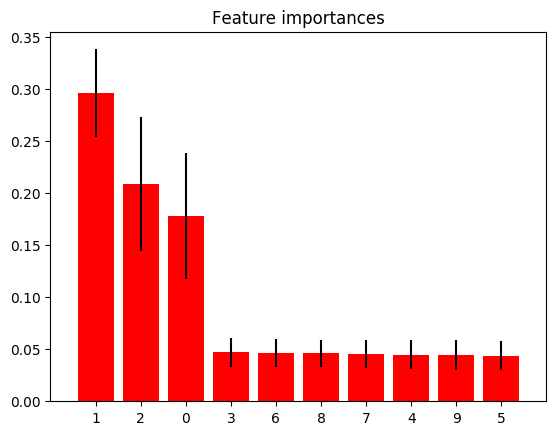

(-1, 10)

In [3]:
# Build a classification task using 3 informative features
x, y = *make_classification(
  n_samples: 1000,
  n_features: 10,
  n_informative: 3,
  n_redundant: 0,
  n_repeated: 0,
  n_classes: 2,
  random_state: 0,
  shuffle: false
)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier.new(n_estimators: 250, random_state: 0)

forest.fit(x, y)
importances = forest.feature_importances_
std = np.std(forest.estimators_.map {|tree| tree.feature_importances_ }, axis: 0)
indices = np.argsort(importances)[(-1..0).step(-1)]

# Print the feature ranking
puts "Feature ranking:"

x.shape[1].times do |f|
  puts "%d. feature %d (%f)" % [f + 1, indices[f].to_i, importances[indices[f]]]
end

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar([*0...x.shape[1]], importances[indices],
        color: "r", yerr: std[indices], align: "center")
plt.xticks([*0...x.shape[1]], indices)
plt.xlim([-1, x.shape[1]])

## (2) Pixel importances with a parallel forest of trees

This example is based on the following content of the reference of scikit-learn:

- http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances_faces.html

Fitting ExtraTreesClassifier on faces data with 1 cores...
done in 1.253s


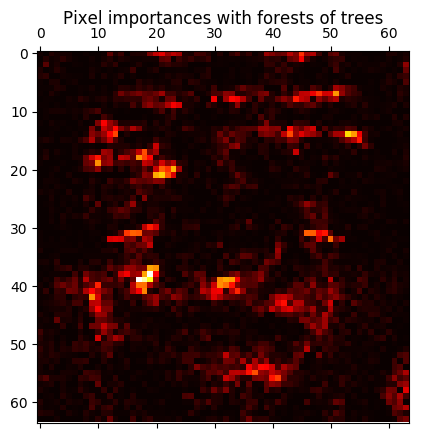

In [4]:
# Number of cores to use to perform parallel fitting of the forest model
n_jobs = 1

# Load the faces datasets
data = fetch_olivetti_faces()
x = data.images.reshape([PyCall.len(data.images), -1])
y = data.target

mask = y < 5  # Limit to 5 classes
x = x[mask]
y = y[mask]

# Build a forest and compute the pixel importances
puts "Fitting ExtraTreesClassifier on faces data with #{n_jobs} cores..."
t0 = Time.now
forest = ExtraTreesClassifier.new(
  n_estimators: 1_000,
  max_features: 128,
  n_jobs: n_jobs,
  random_state: 0
)

forest = forest.fit(x, y)
puts "done in %0.3fs" % (Time.now - t0)
importances = forest.feature_importances_
importances = importances.reshape(data.images[0].shape)

# Plot pixel importances
plt.matshow(importances, cmap: plt.cm.__dict__[:hot])
plt.title("Pixel importances with forests of trees")